In [1]:
import sys
sys.path.append('..')

# Helper imports
from data import CIFAR10, IMAGENETTE
import utils

# Numerical computing and display imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Other imports
from datetime import datetime
import os

/Users/neddamj/miniforge3/envs/nhash/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and Prepare the Data
folder_path = '../../images/'
dataset = 'imagenette'    
if dataset == 'cifar10':
    images = CIFAR10()
if dataset == 'imagenette':
    images = IMAGENETTE()
x = images.load()
images.save_to_disk(x, folder_path, num_images=100)
folder_path = utils.move_data_to_temp_ram(folder_path, ram_size_mb=50)
del(x)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-04-08 11:31:08.295721: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[INFO] Images saved
[INFO] RAM Disk Already Exists...
[INFO] RAM Disk Cleared...
[INFO] Files moved to temp RAM...


In [147]:
attack_hamming_threshold = int(0.4 * 128)
#attack_hamming_threshold = int(0.1  * 256)

In [148]:
attack_hamming_threshold

51

In [167]:
# Threshold-hyperparameter mappings
threshold_hyperparam = {
    '1':  {'simba_hamming_threshold': 7,  'simba_l2_threshold': 20, 'hsja_l2_threshold': 8},
    '6':  {'simba_hamming_threshold': 10, 'simba_l2_threshold': 20, 'hsja_l2_threshold': 12},
    '12': {'simba_hamming_threshold': 20, 'simba_l2_threshold': 28, 'hsja_l2_threshold': 12},
    '25': {'simba_hamming_threshold': 25, 'simba_l2_threshold': 30, 'hsja_l2_threshold': 15},
    '38': {'simba_hamming_threshold': 40, 'simba_l2_threshold': 35, 'hsja_l2_threshold': 15},
    '51': {'simba_hamming_threshold': 55, 'simba_l2_threshold': 35, 'hsja_l2_threshold': 15}
}
"""# PDQ
threshold_hyperparam = {
    '2':  {'simba_hamming_threshold': 7,  'simba_l2_threshold': 20, 'hsja_l2_threshold': 8},
    '12':  {'simba_hamming_threshold': 20, 'simba_l2_threshold': 20, 'hsja_l2_threshold': 12},
    '25': {'simba_hamming_threshold': 40, 'simba_l2_threshold': 28, 'hsja_l2_threshold': 15},
    '51': {'simba_hamming_threshold': 50, 'simba_l2_threshold': 30, 'hsja_l2_threshold': 15},
    '76': {'simba_hamming_threshold': 80, 'simba_l2_threshold': 35, 'hsja_l2_threshold': 15},
    '102': {'simba_hamming_threshold': 110, 'simba_l2_threshold': 35, 'hsja_l2_threshold': 15}
}"""

# SIMBA Hyperparams
simba_epsilon = 0.9
simba_hamming_threshold = threshold_hyperparam[str(attack_hamming_threshold)]['simba_hamming_threshold']                                # <= 5% - 10(max) & 10% - 20 & 20% - 23 
simba_l2_threshold = threshold_hyperparam[str(attack_hamming_threshold)]['simba_l2_threshold']
simba_max_steps = 1500
fast = True

# HSJA Hyperparams
hsja_max_steps = 10
hsja_grad_queries = 20
hsja_l2_threshold = threshold_hyperparam[str(attack_hamming_threshold)]['hsja_l2_threshold']

# Other params
ssim_threshold = 0.8
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H:%M:%S")

In [159]:
# Threshold-hyperparameter mappings
nes_threshold_hyperparam = {
    '2':  {'nes_l2_threshold': 25, 'nes_l2_tolerance': 10, 'hsja_l2_threshold': 10},
    '6':  {'nes_l2_threshold': 35, 'nes_l2_tolerance': 12, 'hsja_l2_threshold': 15},
    '12': {'nes_l2_threshold': 45, 'nes_l2_tolerance': 15, 'hsja_l2_threshold': 20},
    '25': {'nes_l2_threshold': 55, 'nes_l2_tolerance': 20, 'hsja_l2_threshold': 24},
    '38': {'nes_l2_threshold': 75, 'nes_l2_tolerance': 10, 'hsja_l2_threshold': 24},
    '51': {'nes_l2_threshold': 75, 'nes_l2_tolerance': 10, 'hsja_l2_threshold': 24}
}

# NES Hyperparams
nes_mean = -0.025   #-0.1 (PDQ)
nes_std = 0.1       #0.001 (PDQ)
nes_sigma = 0.7
nes_eps = 0.1                      
nes_l2_threshold = nes_threshold_hyperparam[str(attack_hamming_threshold)]['nes_l2_threshold'] 
nes_l2_tolerance = nes_threshold_hyperparam[str(attack_hamming_threshold)]['nes_l2_tolerance'] 
nes_num_samples = 50

In [168]:
zo_threshold_hyperparam = {
    '2':  {'zo_l2_threshold': 25, 'zo_l2_tolerance': 10},
    '6':  {'zo_l2_threshold': 35, 'zo_l2_tolerance': 12},
    '12': {'zo_l2_threshold': 45, 'zo_l2_tolerance': 15},
    '25': {'zo_l2_threshold': 55, 'zo_l2_tolerance': 20},
    '38': {'zo_l2_threshold': 75, 'zo_l2_tolerance': 10},
    '51': {'zo_l2_threshold': 75, 'zo_l2_tolerance': 10}
}  

# ZO-SignSGD Hyperparameters
zo_max_queries = 50
zo_epsilon = 0.1
zo_upper_tolerance = 10 
zo_lower_tolerance = 5
zo_l2_threshold = zo_threshold_hyperparam[str(attack_hamming_threshold)]['zo_l2_threshold'] 
zo_l2_tolerance = zo_threshold_hyperparam[str(attack_hamming_threshold)]['zo_l2_tolerance'] 
zo_search_steps = 50

In [169]:
# Soft-Label Attack imports
from zo_signsgd import ZOSignSGDttack
from simba import SimBAttack
from nes import NESAttack

zosignsgd = ZOSignSGDttack(max_queries=zo_max_queries, 
                           epsilon=zo_epsilon, 
                           l2_threshold=zo_l2_threshold,
                           l2_tolerance=zo_l2_tolerance,
                           search_steps=zo_search_steps)
simba = SimBAttack(eps=simba_epsilon,
                   hamming_threshold=simba_hamming_threshold,
                   l2_threshold=simba_l2_threshold,
                   max_steps=simba_max_steps,
                   fast=fast)
nes = NESAttack(mean=nes_mean,
                std=nes_std,
                sigma=nes_sigma,
                eps=nes_eps,
                l2_threshold=nes_l2_threshold,
                l2_tolerance=nes_l2_tolerance,
                num_samples=nes_num_samples)

In [170]:
# Hard-label Attack imports
from hsja import HSJAttack

hsja = HSJAttack(max_iters=hsja_max_steps, 
                 grad_queries=hsja_grad_queries, 
                 l2_threshold=hsja_l2_threshold, 
                 hamming_threshold=attack_hamming_threshold)

In [171]:
# Joint Attack
from joint_attack import JointAttack

joint_attack = JointAttack(soft_label=simba, 
                           hard_label=hsja)

In [172]:
for i in range(100):
    i=4
    # Format the path to the input image
    img_path = f'../../images/{i+1}.bmp' 
    _, _, _, _, path, filetype = img_path.split('.')
    img_path = path.split('/')
    img_path = f'{folder_path}{img_path[2]}.{filetype}'

    # Attack NeuralHash 
    orig_img, sl_img, adv_img, sl_num_queries, hl_num_queries = joint_attack.attack(img_path)
    
    # Save the simba image and the final image
    utils.save_img(f'../../images/{i+1}_sl.bmp', sl_img)  
    utils.save_img(f'../../images/{i+1}_final.bmp', adv_img)

    # Attack Metrics
    orig_hash  = utils.compute_hash(orig_img)
    sl_hash = utils.compute_hash(sl_img)
    adv_hash = utils.compute_hash(adv_img)
    simba_hamming_dist = utils.distance(orig_hash, sl_hash, "hamming")
    final_hamming_dist = utils.distance(orig_hash, adv_hash, "hamming")
    sl_l2_dist = utils.distance(orig_img, sl_img, 'l2')
    final_l2_dist = utils.distance(orig_img, adv_img, 'l2')
    sl_ssim = utils.distance(orig_img, sl_img, 'ssim')
    final_ssim = utils.distance(orig_img, adv_img.astype(np.uint8), 'ssim')
    total_queries = sl_num_queries + hl_num_queries
    sl_success = (simba_hamming_dist >= attack_hamming_threshold) and (sl_ssim >= ssim_threshold)
    success = (final_hamming_dist >= attack_hamming_threshold) and (final_ssim >= ssim_threshold)


    attack_metrics = {
        'Image Path':         [img_path],
        'Soft-Label Success': [sl_success],
        'Success':            [success],
        'Queries':            [total_queries],
        'Soft-Label L2':      [sl_l2_dist],
        'Final L2':           [final_l2_dist],
        'Sotf-Label SSIM':    [sl_ssim],
        'Final SSIM':         [final_ssim],
        'Soft-Label Hamming': [simba_hamming_dist],
        'Final Hamming':      [final_hamming_dist]
    }

    # Save the results
    df = pd.DataFrame.from_dict(attack_metrics)
    if type(joint_attack.soft_label) == SimBAttack:
        sl_attack = 'simba'
        eps = simba_epsilon
    elif type(joint_attack.soft_label) == NESAttack:
        sl_attack = 'nes'
        eps = nes_eps
    else:
        sl_attack = 'zo_signsgd'
        eps = zo_epsilon
    file_path = f'metrics/{sl_attack}/{eps}/pdq_hamm_{attack_hamming_threshold}_l2_{hsja_l2_threshold}_{dt_string}.csv'
    if os.path.exists(file_path):
        df.to_csv(file_path, mode='a', index=False, header=False)
    else: 
        df.to_csv(file_path, index=False, header=True) 

    break 

[INFO] SimBA starting...
Step: 1 L2 Dist: 0.06562040001153946 Hamming Dist: 2
Step: 2 L2 Dist: 0.06562040001153946 Hamming Dist: 2
Step: 3 L2 Dist: 0.06562040001153946 Hamming Dist: 2
Step: 4 L2 Dist: 0.06562040001153946 Hamming Dist: 2
Step: 5 L2 Dist: 0.06562040001153946 Hamming Dist: 2
Step: 6 L2 Dist: 1.0077286958694458 Hamming Dist: 4
Step: 7 L2 Dist: 1.0077286958694458 Hamming Dist: 4
Step: 8 L2 Dist: 1.1744688749313354 Hamming Dist: 4
Step: 9 L2 Dist: 1.1744688749313354 Hamming Dist: 4
Step: 10 L2 Dist: 1.1744688749313354 Hamming Dist: 4
Step: 11 L2 Dist: 1.1744688749313354 Hamming Dist: 4
Step: 12 L2 Dist: 1.1744688749313354 Hamming Dist: 4
Step: 13 L2 Dist: 1.1744688749313354 Hamming Dist: 4
Step: 14 L2 Dist: 1.1744688749313354 Hamming Dist: 4
Step: 15 L2 Dist: 1.1744688749313354 Hamming Dist: 4
Step: 16 L2 Dist: 1.1744688749313354 Hamming Dist: 4
Step: 17 L2 Dist: 1.1744688749313354 Hamming Dist: 4
Step: 18 L2 Dist: 1.1744688749313354 Hamming Dist: 4
Step: 19 L2 Dist: 1.17446

In [173]:
def plot_results(orig_img, sl_img, adv_img, hamming_threshold):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))
    #fig.suptitle(f'Hamming Threshold: {hamming_threshold}')
    ax1.imshow(orig_img)
    ax1.set_title('Orginal Image') 
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.imshow(sl_img)
    ax2.set_title('Noisy Soft-Label Image')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3.imshow(adv_img.astype(np.uint8))
    ax3.set_title('Denoised Final Image')
    ax3.set_xticks([])
    ax3.set_yticks([])

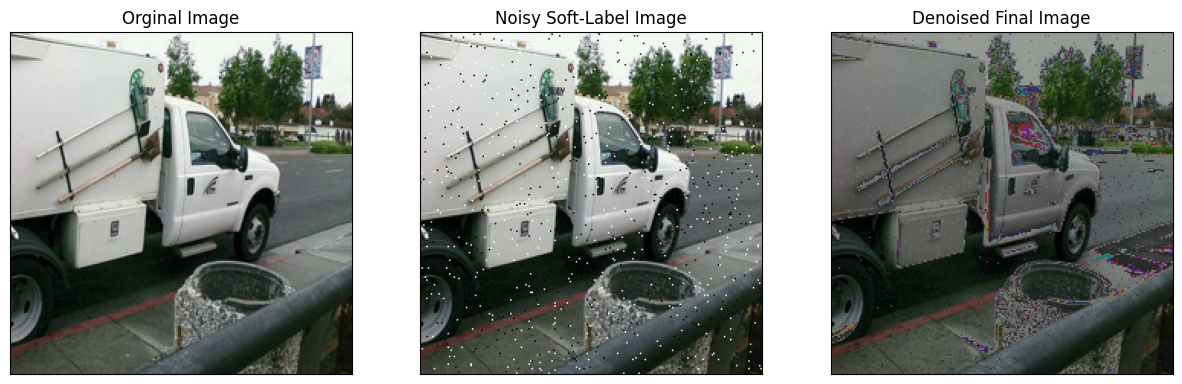

In [174]:
# Show the images/results
plot_results(orig_img, sl_img, adv_img, attack_hamming_threshold) # 4

### Analyze the Results

In [ ]:
df = pd.read_csv(file_path)
df.head()

,Image Path,Soft-Label Success,Success,Queries,Soft-Label L2,Final L2,Sotf-Label SSIM,Final SSIM,Soft-Label Hamming,Final Hamming
0,/Volumes/TempRAM/6.bmp,False,True,104,38.020299,8.302743,0.897877,0.98984,0,14


In [ ]:
queries = np.array(df['Queries'])
avg_queries = queries.mean()
print(f'The attacks were completed in {int(avg_queries)} queries on average')

The attacks were completed in 104 queries on average


In [ ]:
success = np.array(df['Success'])
ASR = success.mean()
print(f'The ASR is {100*ASR:.2f}% ')

The ASR is 100.00% 


In [ ]:
hamming_dist = np.array(df['Final Hamming'])
avg_hamm = hamming_dist.mean()
print(f'The average hamming distance after joint attack is {avg_hamm}')

The average hamming distance after joint attack is 14.0


In [ ]:
simba_l2_dist = np.array(df['Soft-Label L2'])
simba_avg_l2 = simba_l2_dist.mean()
simba_l2_std = np.std(simba_l2_dist)
print(f'The average L2 distortion after the soft-label attack is {simba_avg_l2:.4f} +- {simba_l2_std:.4f}')

final_l2_dist = np.array(df['Final L2'])
final_avg_l2 = final_l2_dist.mean()
final_l2_std = np.std(final_l2_dist)
print(f'The average L2 distortion after the complete attack is {final_avg_l2:.4f} +- {final_l2_std}')

The average L2 distortion after the soft-label attack is 38.0203 +- 0.0000
The average L2 distortion after the complete attack is 8.3027 +- 0.0


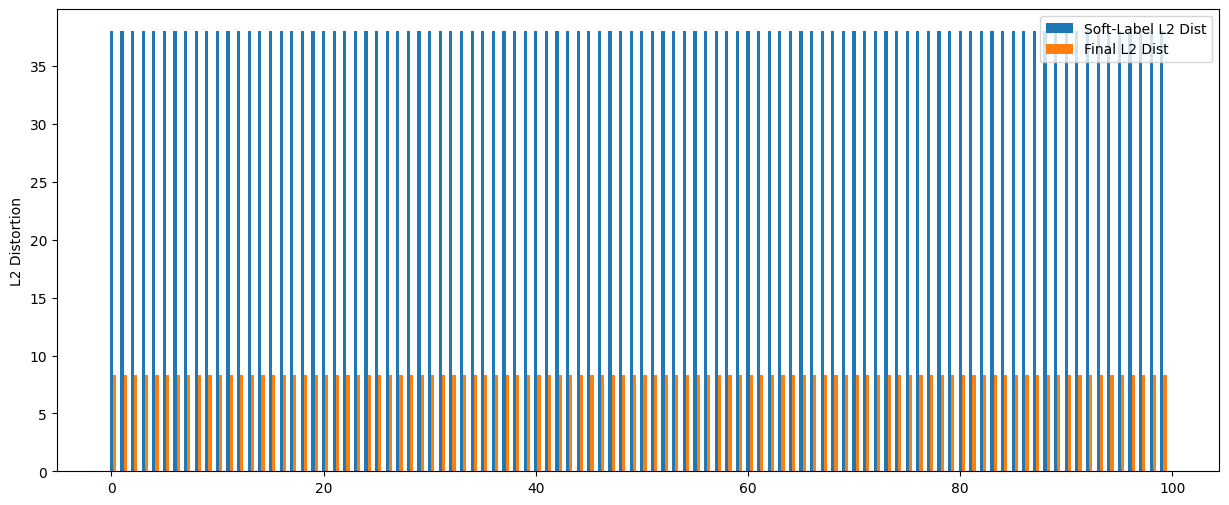

In [ ]:
index = np.arange(100)
bar_width = 0.3
fig, ax = plt.subplots(figsize=(15,6)) 
simba_distortion = ax.bar(index, df['Soft-Label L2'], bar_width, label='Soft-Label L2 Dist')
output_distortion = ax.bar(index + bar_width, df['Final L2'], bar_width, label='Final L2 Dist')
ax.set_label('Image')
ax.set_ylabel('L2 Distortion')
ax.legend()

plt.show()